<a href="https://colab.research.google.com/github/maxskoda/RefNX_GUI_v1/blob/master/Bilayer_On_Gold_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Installs
!pip install refnx
!pip install gspread

In [3]:
# @title Imports

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

from google.colab import files

gc = gspread.authorize(creds)

from IPython.display import Javascript

import pandas as pd
import re
import re
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from refnx.reflect import SLD, Slab, ReflectModel, MixedReflectModel, FunctionalForm, Structure, sld_profile, Stack
from refnx.analysis import Objective, GlobalObjective, Parameter, CurveFitter, Transform, process_chain

from refnx.dataset import ReflectDataset

from google.colab import sheets

In [19]:
# @title Helper functions

# Function to create parameters from the table
def create_parameter(name, value, lower, upper, vary, dist_type='uniform', param1=0, param2=0):
    if dist_type == 'uniform':
        return Parameter(value, name=name, bounds=(lower, upper), vary=vary)
    elif dist_type == 'gaussian':
        return Parameter(value, name=name, bounds=stats.norm(param1, param2), vary=vary)

# Function to convert Google sheet to csv format
def convert_gglsht_url(url):
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'
    new_url = re.sub(pattern, replacement, url)
    return new_url

def pretty_plot(model, data):
  # Define the Q range for the reflectivity calculation
  q = np.linspace(0.005, 0.33, 300)  # Q values from 0.005 to 0.3 Å^-1
  # Calculate the reflectivity
  reflectivity = model(q)
  # Plot the calculated reflectivity
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
  # plt.figure(figsize=(4, 3))
  ax1.plot(q, reflectivity, label='Calculated Reflectivity')
  ax1.errorbar(data.x , data.y, data.y_err, label='Measured Reflectivity')
  # ax1.xlabel('Q (Å$^{-1}$)')
  ax1.set_xlabel('Q')
  ax1.set_ylabel('Reflectivity')
  ax1.set_yscale('log')
  ax1.set_xscale('log')
  ax1.legend()
  ax1.grid(True)

  # plot the SLD profilea
  # ax2.plot(*s2.sld_profile(align=-1),label='structure 2')
  ax2.plot(*s1.sld_profile(align=-1),label='structure 1')
  ax2.set_ylabel('SLD /$10^{-6} \AA^{-2}$')
  ax2.set_xlabel('distance / $\AA$')
  ax2.legend()
  fig.show()

In [5]:
# @title Data entry sheets

# Create a new interactive sheet and add data to it.
# sheet = sheets.InteractiveSheet()

# Open existing sheet
sheet = gc.open('RefNX Parameter Table')

In [66]:
# @title Refresh spreadsheet and re-generate parameters
# url = 'https://docs.google.com/spreadsheets/d/1aGrL-jpTJ-cuIqSGuJtwt4svpAMQA2-I3nzZrknrnvo/edit?gid=0#gid=0'
# new_url = convert_gglsht_url(url)
# print(new_url)

def refresh_spreadsheet():
  # Open the Google Sheet using its key
  sheet = gc.open_by_key('1aGrL-jpTJ-cuIqSGuJtwt4svpAMQA2-I3nzZrknrnvo')

  # Get the first worksheet
  worksheet = sheet.get_worksheet(0)
  worksheet_bulk_ins = sheet.worksheet('Bulk ins')
  worksheet_bulk_outs = sheet.worksheet('Bulk outs')
  worksheet_scales = sheet.worksheet('Scales')
  worksheet_backgrounds = sheet.worksheet('Backgrounds')

  # Convert the worksheet to a Pandas DataFrame
  df = pd.DataFrame(worksheet.get_all_records())
  df_bulk_ins = pd.DataFrame(worksheet_bulk_ins.get_all_records())
  df_bulk_outs = pd.DataFrame(worksheet_bulk_outs.get_all_records())
  df_scales = pd.DataFrame(worksheet_scales.get_all_records())
  df_backgrounds = pd.DataFrame(worksheet_backgrounds.get_all_records())

  parameters = {}
  # Regular parameters
  for index, row in df.iterrows():
      parameters[row['Name']] = create_parameter(
          name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE',
          dist_type=row['Type'],
          param1=row['Type Param 1'],
          param2=row['Type Param 2']
      )
  # Bulk parameters:
  for index, row in df_bulk_ins.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )
  for index, row in df_bulk_outs.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )

  for index, row in df_scales.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )
  for index, row in df_backgrounds.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )

  return parameters

parameters = refresh_spreadsheet()

In [73]:
from math import e
# @title Generate and plot models
Plot = "No" # @param ["Yes","No"]

# execute function above to re-genearate parameters from spreadsheet
parameters = refresh_spreadsheet()

# Open the 'Layers' worksheet
worksheet_layers = sheet.worksheet('Layers')
worksheet_bulk_ins = sheet.worksheet('Bulk ins')
worksheet_bulk_outs = sheet.worksheet('Bulk outs')
worksheet_scales = sheet.worksheet('Scales')
worksheet_backgrounds = sheet.worksheet('Backgrounds')

# contrast_1 = sheet.worksheet('Contrast 1')
# contrast_2 = sheet.worksheet('Contrast 2')

# Convert the worksheet to a Pandas DataFrame
df_layers = pd.DataFrame(worksheet_layers.get_all_records())
# df_contrast_1 = pd.DataFrame(contrast_1.get_all_records())
# df_contrast_2 = pd.DataFrame(contrast_2.get_all_records())

# Create a dict to store the layers
layers = {}

# Iterate through the rows in the DataFrame
for index, row in df_layers.iterrows():
  # Get the layer name, thickness, SLD, and roughness parameters
  thickness_param_name = row['Thickness']
  sld_param_name = row['SLD']
  roughness_param_name = row['Roughness']
  hydration = row['Hydration']

  # Create the Slab object using the parameters from the table
  layer = Slab(
      name=row['Layer Name'],
      thick=parameters[thickness_param_name],
      sld=parameters[sld_param_name],
      rough=parameters[roughness_param_name] if roughness_param_name in parameters else Parameter(5), # Default roughness to 5 if not specified
      vfsolv=parameters[hydration]/100 if hydration in parameters else Parameter(0) # Default to no hydration if not specified
  )

  # Add the layer to the dict
  layers[row['Layer Name']] = layer

#################################
# Assemble layers for Contrast 1:
# Get all worksheets in the spreadsheet.
worksheets = sheet.worksheets()

# Create figure for SLD plotting:
if Plot == "Yes":
  fig1, ax = plt.subplots(figsize=(5, 3))

# Iterate over the worksheets and process those named 'Contrast xxx'.
structures = {}
models = {}
for worksheet in worksheets:
  if worksheet.title.startswith('Contrast'):
    # Access and process the data in the worksheet.
    df_contrast = pd.DataFrame(worksheet.get_all_records())

    # Example: Print the title and data of the worksheet.
    # print(f'Worksheet Title: {worksheet.title}')

    scale_name = worksheet.acell('C2').value
    background_name = worksheet.acell('D2').value
    bulk_in_name = worksheet.acell('B2').value

    # Create the bulk media
    bulk_in = SLD(value=parameters[bulk_in_name], name='bulk in')
    bulk_out = SLD(value=parameters[df_contrast['Layer'].iloc[-1]], name='bulk out') # last entry
    scale = parameters[scale_name]
    background = parameters[background_name]

    # Create the structure using the list of layers

    structure = bulk_in(0,0)

    for index, row in df_contrast.iterrows():
      layer_name = row['Layer']

      try:
        layer = layers[layer_name]
        structure = structure | layer
      except KeyError:
        pass # empty rows

    # Add the last layer
    structure = structure | bulk_out(0, 5) #parameters['Bilayer rough'])
    structure.name = worksheet.title
    structures[worksheet.title] = structure

    # Add structure to model
    models['model '+worksheet.title] = ReflectModel(structure, scale=scale, bkg=background)

    # # Upload data and create objective
    # uploaded_files = files.upload()
    # for file_name in uploaded_files:
    #   dataset = ReflectDataset(file_name)
    #   objective = Objective(models['model '+worksheet.title], dataset, name='objective '+worksheet.title)

    # print the layer structure
    print(f"================= {worksheet.title} =================")
    print(df_contrast)
    print("==================")

    # Plot the structure
    if Plot == "Yes":
      structure.plot(fig=fig1);

if Plot == "Yes":
  # Change colour for each contrast
  prop_cycle = plt.rcParams['axes.prop_cycle']
  colors = prop_cycle.by_key()['color']

  lines = ax.get_lines()
  for i, line in enumerate(lines):
    line.set_color(colors[i])
  ax.legend(structures.keys())#, loc='upper left')

print('\n\n\The following models have been created:\n')
for key in models:
  print(key)


================= Contrast 1 =================
       Index          Layer    Scale    Background
0    bulk in             Si  Scale 1  Background 1
1                     oxide                       
2                        Cr                       
3                        Au                       
4                 SAM tails                       
5                 SAM heads                       
6             Central water                       
7             Bilayer heads                       
8             Bilayer tails                       
9             Bilayer tails                       
10            Bilayer heads                       
11  bulk out            D2O                       
================= Contrast 2 =================
       Index          Layer    Scale    Background
0    bulk in             Si  Scale 1  Background 1
1                     oxide                       
2                        Cr                       
3                        Au            

In [64]:
# @title Load files
import ipywidgets as widgets
from IPython.display import display
import os

# Get the number of contrasts
worksheets = sheet.worksheets()
contrast_count = sum(1 for worksheet in worksheets if worksheet.title.startswith('Contrast'))

# Create file selection dropdowns for each contrast
file_dropdowns = {}
for i in range(1, contrast_count + 1):
  file_dropdown = widgets.Dropdown(
      options=[],
      description=f'Contrast {i}:',
      disabled=False,
  )
  file_dropdowns[f'Contrast {i}'] = file_dropdown

# Create a container for the widgets
form_items = list(file_dropdowns.values())

# Create the form
form = widgets.VBox(form_items)

# Display the form
display(form)

# Function to refresh dropdowns with files from /content
def refresh_dropdowns():
  files_in_content = [f for f in os.listdir('/content') if os.path.isfile(os.path.join('/content', f))]
  for dropdown in file_dropdowns.values():
    dropdown.options = files_in_content

# Refresh dropdowns initially
refresh_dropdowns()

# Function to handle file selection
def handle_selection(change):
  selected_filename = change.new
  # print(f'Selected file for {change.owner.description}: {selected_filename}')
  # You can process the selected file here

# Assign the selection handler to each file dropdown widget
for dropdown_widget in file_dropdowns.values():
  dropdown_widget.observe(handle_selection, names='value')

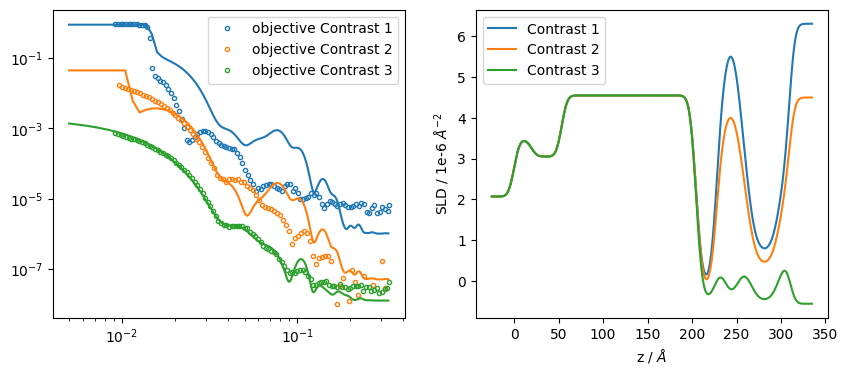

In [74]:
# @title Plot Objectives and Data
objectives = {}
for contrast_name, dropdown in file_dropdowns.items():
  if dropdown.value:  # Check if a file is selected
    try:
      dataset = ReflectDataset(dropdown.value)
      objective = Objective(models['model ' + contrast_name], dataset, name='objective ' + contrast_name)
      objectives[contrast_name] = objective
    except Exception as e:
      print(f"Error creating objective for {contrast_name}: {e}")
  else:
    print(f"No file selected for {contrast_name}")

# Now you have a dictionary 'objectives' containing the objective for each contrast.
# Creat figure for data plotting:
# Change colour for each contrast
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig2, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
q = np.linspace(0.005, 0.33, 300)
for col, objective in enumerate(objectives.values()):
  ax1.plot(objective.data.x, objective.data.y * 20**-col, marker='o', linestyle='', color=colors[col],
          markersize=3, mew=1, markerfacecolor='none', label=objective.name)
  ax1.plot(q, objective.model(q) * 20**-col)

  objective.model.structure.plot(fig=fig2)

ax1.legend();
ax1.set_xscale('log')
ax1.set_yscale('log')

lines = ax2.get_lines()
for i, line in enumerate(lines):
  line.set_color(colors[i])
ax2.legend(structures.keys());#, loc='upper left')